# XGBoost Regressor training
- This is an auto-generated notebook.
- To reproduce these results, attach this notebook to a cluster with runtime version **16.0.x-cpu-ml-scala2.12**, and rerun it.
- Compare trials in the [MLflow experiment](#mlflow/experiments/1915683698551880).
- Clone this notebook into your project folder by selecting **File > Clone** in the notebook toolbar.

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "price"

## Load Data

In [0]:
import mlflow
import os
import uuid
import shutil
import pandas as pd

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)


# Download the artifact and read it into a pandas DataFrame
input_data_path = mlflow.artifacts.download_artifacts(run_id="661f049e94384ea6bd1725c9b0d126a9", artifact_path="data", dst_path=input_temp_dir)

df_loaded = pd.read_parquet(os.path.join(input_data_path, "training_data"))
# Delete the temp data
shutil.rmtree(input_temp_dir)

# Preview data
display(df_loaded.head(5))

latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_period,state,price,_automl_split_col_0000
45.50726,-122.62083,Entire home/apt,2,22,2.27,4,166,12.424657534246576,OR,88,train
40.73977,-73.85427,Private room,1,7,1.83,1,180,12.252054794520548,NY,70,train
40.76257,-73.97725,Private room,30,5,1.02,1,365,12.136986301369863,NY,220,train
44.93325,-93.16013,Entire home/apt,2,45,0.95,3,308,12.331506849315069,MN,137,train
45.11296,-93.46266,Entire home/apt,2,32,1.81,1,86,12.443835616438356,MN,345,train


In [0]:
df_loaded.shape

(106635, 12)

### Select supported columns
Select only the columns that are supported. This allows us to train a model that can predict on a dataset that has extra columns that are not used in training.
`[]` are dropped in the pipelines. See the Alerts tab of the AutoML Experiment page for details on why these columns are dropped.

In [0]:
from databricks.automl_runtime.sklearn.column_selector import ColumnSelector
supported_cols = ["room_type", "latitude", "calculated_host_listings_count", "reviews_per_month", "number_of_reviews", "longitude", "last_review_period", "minimum_nights", "availability_365", "state"]
col_selector = ColumnSelector(supported_cols)

## Preprocessors

### Numerical columns

Missing values for numerical columns are imputed with mean by default.

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

num_imputers = []
num_imputers.append(("impute_mean", SimpleImputer(), ["availability_365", "calculated_host_listings_count", "last_review_period", "latitude", "longitude", "minimum_nights", "number_of_reviews", "reviews_per_month"]))

numerical_pipeline = Pipeline(steps=[
    ("converter", FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors='coerce'))),
    ("imputers", ColumnTransformer(num_imputers)),
    ("standardizer", StandardScaler()),
])

numerical_transformers = [("numerical", numerical_pipeline, ["latitude", "calculated_host_listings_count", "reviews_per_month", "number_of_reviews", "longitude", "last_review_period", "minimum_nights", "availability_365"])]

### Categorical columns

#### Low-cardinality categoricals
Convert each low-cardinality categorical column into multiple binary columns through one-hot encoding.
For each input categorical column (string or numeric), the number of output columns is equal to the number of unique values in the input column.

In [0]:
from databricks.automl_runtime.sklearn import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

one_hot_imputers = []

one_hot_pipeline = Pipeline(steps=[
    ("imputers", ColumnTransformer(one_hot_imputers, remainder="passthrough")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="indicator")),
])

categorical_one_hot_transformers = [("onehot", one_hot_pipeline, ["room_type", "state"])]

In [0]:
from sklearn.compose import ColumnTransformer

transformers = numerical_transformers + categorical_one_hot_transformers

preprocessor = ColumnTransformer(transformers, remainder="passthrough", sparse_threshold=0)

## Train - Validation - Test Split
The input data is split by AutoML into 3 sets:
- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters of the model)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

`_automl_split_col_0000` contains the information of which set a given row belongs to.
We use this column to split the dataset into the above 3 sets. 
The column should not be used for training so it is dropped after split is done.

In [0]:
# AutoML completed train - validation - test split internally and used _automl_split_col_0000 to specify the set
split_train_df = df_loaded.loc[df_loaded._automl_split_col_0000 == "train"]
split_val_df = df_loaded.loc[df_loaded._automl_split_col_0000 == "validate"]
split_test_df = df_loaded.loc[df_loaded._automl_split_col_0000 == "test"]

# Separate target column from features and drop _automl_split_col_0000
X_train = split_train_df.drop([target_col, "_automl_split_col_0000"], axis=1)
y_train = split_train_df[target_col]

X_val = split_val_df.drop([target_col, "_automl_split_col_0000"], axis=1)
y_val = split_val_df[target_col]

X_test = split_test_df.drop([target_col, "_automl_split_col_0000"], axis=1)
y_test = split_test_df[target_col]

In [0]:
X_train.shape

(64091, 10)

## Train regression model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/1915683698551880)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment
- To view the full list of tunable hyperparameters, check the output of the cell below

In [0]:
from xgboost import XGBRegressor

help(XGBRegressor)

Help on class XGBRegressor in module xgboost.sklearn:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  XGBRegressor(*, objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror', **kwargs: Any) -> None
 |
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  See :doc:`/python/sklearn_estimator` for more information.
 |
 |  Parameters
 |  ----------
 |
 |      n_estimators : Optional[int]
 |          Number of gradient boosted trees.  Equivalent to number of boosting
 |          rounds.
 |
 |      max_depth :  Optional[int]
 |          Maximum tree depth for base learners.
 |      max_leaves :
 |          Maximum number of leaves; 0 indicates no limit.
 |      max_bin :
 |          If using histogram-based algorithm, maximum number of bins per feature
 |      grow_policy :
 |          Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
 |          depth-wis

### Define the objective function
The objective function used to find optimal hyperparameters. By default, this notebook only runs
this function once (`max_evals=1` in the `hyperopt.fmin` invocation) with fixed hyperparameters, but
hyperparameters can be tuned by modifying `space`, defined below. `hyperopt.fmin` will then use this
function's return value to search the space to minimize the loss.

In [0]:
import mlflow
from mlflow.models import Model, infer_signature, ModelSignature
from mlflow.pyfunc import PyFuncModel
from mlflow import pyfunc
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials


# Create a separate pipeline to transform the validation dataset. This is used for early stopping.
pipeline_val = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
])

mlflow.sklearn.autolog(disable=True)
pipeline_val.fit(X_train, y_train)
X_val_processed = pipeline_val.transform(X_val)

def objective(params):
  with mlflow.start_run(experiment_id="1915683698551880") as mlflow_run:
    xgb_regressor = XGBRegressor(**params)

    model = Pipeline([
        ("column_selector", col_selector),
        ("preprocessor", preprocessor),
        ("regressor", xgb_regressor),
    ])

    # Enable automatic logging of input samples, metrics, parameters, and models
    mlflow.sklearn.autolog(
        log_input_examples=True,
        silent=True,
    )

    model.fit(X_train, y_train, regressor__early_stopping_rounds=5, regressor__verbose=False, regressor__eval_set=[(X_val_processed,y_val)])

    
    # Log metrics for the training set
    mlflow_model = Model()
    pyfunc.add_to_model(mlflow_model, loader_module="mlflow.sklearn")
    pyfunc_model = PyFuncModel(model_meta=mlflow_model, model_impl=model)
    training_eval_result = mlflow.evaluate(
        model=pyfunc_model,
        data=X_train.assign(**{str(target_col):y_train}),
        targets=target_col,
        model_type="regressor",
        evaluator_config = {"log_model_explainability": False,
                            "metric_prefix": "training_"  }
    )
    # Log metrics for the validation set
    val_eval_result = mlflow.evaluate(
        model=pyfunc_model,
        data=X_val.assign(**{str(target_col):y_val}),
        targets=target_col,
        model_type="regressor",
        evaluator_config= {"log_model_explainability": False,
                           "metric_prefix": "val_"  }
   )
    xgb_val_metrics = val_eval_result.metrics
    # Log metrics for the test set
    test_eval_result = mlflow.evaluate(
        model=pyfunc_model,
        data=X_test.assign(**{str(target_col):y_test}),
        targets=target_col,
        model_type="regressor",
        evaluator_config= {"log_model_explainability": False,
                           "metric_prefix": "test_"  }
   )
    xgb_test_metrics = test_eval_result.metrics

    loss = xgb_val_metrics["val_root_mean_squared_error"]

    # Truncate metric key names so they can be displayed together
    xgb_val_metrics = {k.replace("val_", ""): v for k, v in xgb_val_metrics.items()}
    xgb_test_metrics = {k.replace("test_", ""): v for k, v in xgb_test_metrics.items()}

    return {
      "loss": loss,
      "status": STATUS_OK,
      "val_metrics": xgb_val_metrics,
      "test_metrics": xgb_test_metrics,
      "model": model,
      "run": mlflow_run,
    }

(2024-12-02 20:02:19) WARNING: Hyperopt is deprecated for Databricks runtime for machine learning and will not be pre-installed in the next major version.


### Configure the hyperparameter search space
Configure the search space of parameters. Parameters below are all constant expressions but can be
modified to widen the search space. For example, when training a decision tree regressor, to allow
the maximum tree depth to be either 2 or 3, set the key of 'max_depth' to
`hp.choice('max_depth', [2, 3])`. Be sure to also increase `max_evals` in the `fmin` call below.

See https://docs.databricks.com/applications/machine-learning/automl-hyperparam-tuning/index.html
for more information on hyperparameter tuning as well as
http://hyperopt.github.io/hyperopt/getting-started/search_spaces/ for documentation on supported
search expressions.

For documentation on parameters used by the model in use, please see:
https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor

NOTE: The above URL points to a stable version of the documentation corresponding to the last
released version of the package. The documentation may differ slightly for the package version
used by this notebook.

In [0]:
space = {
  "colsample_bytree": 0.6186426192274185,
  "learning_rate": 0.006868840971201565,
  "max_depth": 12,
  "min_child_weight": 12,
  "n_estimators": 1754,
  "n_jobs": 100,
  "subsample": 0.6242788541564421,
  "verbosity": 0,
  "random_state": 817055738,
}

### Run trials
When widening the search space and training multiple models, switch to `SparkTrials` to parallelize
training on Spark:
```
from hyperopt import SparkTrials
trials = SparkTrials()
```

NOTE: While `Trials` starts an MLFlow run for each set of hyperparameters, `SparkTrials` only starts
one top-level run; it will start a subrun for each set of hyperparameters.

See http://hyperopt.github.io/hyperopt/scaleout/spark/ for more info.

In [0]:
trials = Trials()
fmin(objective,
     space=space,
     algo=tpe.suggest,
     max_evals=1,  # Increase this when widening the hyperparameter search space.
     trials=trials)

best_result = trials.best_trial["result"]
model = best_result["model"]
mlflow_run = best_result["run"]

display(
  pd.DataFrame(
    [best_result["val_metrics"], best_result["test_metrics"]],
    index=pd.Index(["validation", "test"], name="split")).reset_index())

set_config(display="diagram")
model

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/databricks/python/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

2024/12/02 20:04:16 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.

2024/12/02 20:04:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of langchain. If you encounter errors durin

100%|██████████| 1/1 [02:06<00:00, 126.58s/trial, best loss: 74.93342731045858]


split,score,example_count,mean_absolute_error,mean_squared_error,root_mean_squared_error,sum_on_target,mean_on_target,r2_score,max_error,mean_absolute_percentage_error
validation,0.43035749125640477,21292,54.67639776640495,5615.018528491781,74.93342731045858,3387247,159.08543114784896,0.43035749125640477,403.5372543334961,0.4187100606010535
test,0.4189553952847963,21252,55.08570369515472,5647.127509570454,75.14737194054396,3383949,159.22967250141164,0.4189553952847963,381.1429748535156,0.4157732186804585


Pipeline(steps=[('column_selector',
                 ColumnSelector(cols=['room_type', 'latitude',
                                      'calculated_host_listings_count',
                                      'reviews_per_month', 'number_of_reviews',
                                      'longitude', 'last_review_period',
                                      'minimum_nights', 'availability_365',
                                      'state'])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('numerical',
                                                  Pipeline(steps...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.006868840971201565, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=12,
                              max_leaves=None, min_child_weight=12, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1754, n_jobs=100,
                              num_parallel_tree=None, random_state=817055738, ...))])

### Patch pandas version in logged model

Ensures that model serving uses the same version of pandas that was used to train the model.

In [0]:
import mlflow
import os
import shutil
import tempfile
import yaml

run_id = mlflow_run.info.run_id

# Set up a local dir for downloading the artifacts.
tmp_dir = tempfile.mkdtemp()

client = mlflow.tracking.MlflowClient()

# Fix conda.yaml
conda_file_path = mlflow.artifacts.download_artifacts(artifact_uri=f"runs:/{run_id}/model/conda.yaml", dst_path=tmp_dir)
with open(conda_file_path) as f:
  conda_libs = yaml.load(f, Loader=yaml.FullLoader)
pandas_lib_exists = any([lib.startswith("pandas==") for lib in conda_libs["dependencies"][-1]["pip"]])
if not pandas_lib_exists:
  print("Adding pandas dependency to conda.yaml")
  conda_libs["dependencies"][-1]["pip"].append(f"pandas=={pd.__version__}")

  with open(f"{tmp_dir}/conda.yaml", "w") as f:
    f.write(yaml.dump(conda_libs))
  client.log_artifact(run_id=run_id, local_path=conda_file_path, artifact_path="model")

# Fix requirements.txt
venv_file_path = mlflow.artifacts.download_artifacts(artifact_uri=f"runs:/{run_id}/model/requirements.txt", dst_path=tmp_dir)
with open(venv_file_path) as f:
  venv_libs = f.readlines()
venv_libs = [lib.strip() for lib in venv_libs]
pandas_lib_exists = any([lib.startswith("pandas==") for lib in venv_libs])
if not pandas_lib_exists:
  print("Adding pandas dependency to requirements.txt")
  venv_libs.append(f"pandas=={pd.__version__}")

  with open(f"{tmp_dir}/requirements.txt", "w") as f:
    f.write("\n".join(venv_libs))
  client.log_artifact(run_id=run_id, local_path=venv_file_path, artifact_path="model")

shutil.rmtree(tmp_dir)

Adding pandas dependency to conda.yaml


Adding pandas dependency to requirements.txt


## Feature importance

SHAP is a game-theoretic approach to explain machine learning models, providing a summary plot
of the relationship between features and model output. Features are ranked in descending order of
importance, and impact/color describe the correlation between the feature and the target variable.
- Generating SHAP feature importance is a very memory intensive operation, so to ensure that AutoML can run trials without
  running out of memory, we disable SHAP by default.<br />
  You can set the flag defined below to `shap_enabled = True` and re-run this notebook to see the SHAP plots.
- To reduce the computational overhead of each trial, a single example is sampled from the validation set to explain.<br />
  For more thorough results, increase the sample size of explanations, or provide your own examples to explain.
- SHAP cannot explain models using data with nulls; if your dataset has any, both the background data and
  examples to explain will be imputed using the mode (most frequent values). This affects the computed
  SHAP values, as the imputed samples may not match the actual data distribution.

For more information on how to read Shapley values, see the [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

In [0]:
# Set this flag to True and re-run the notebook to see the SHAP plots
shap_enabled = True

  0%|          | 0/100 [00:00<?, ?it/s]

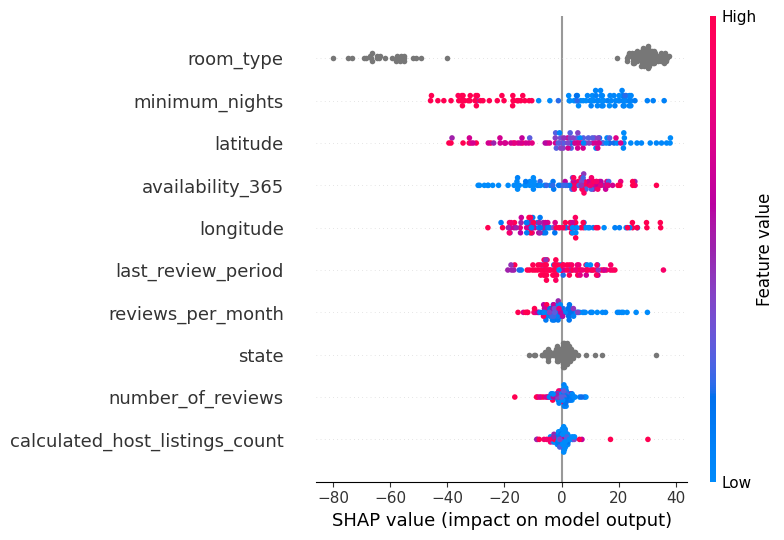

In [0]:
if shap_enabled:
    mlflow.autolog(disable=True)
    mlflow.sklearn.autolog(disable=True)
    from shap import KernelExplainer, summary_plot
    # Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
    train_sample = X_train.sample(n=min(100, X_train.shape[0]), random_state=817055738)

    # Sample some rows from the validation set to explain. Increase the sample size for more thorough results.
    example = X_val.sample(n=min(100, X_val.shape[0]), random_state=817055738)

    # Use Kernel SHAP to explain feature importance on the sampled rows from the validation set.
    predict = lambda x: model.predict(pd.DataFrame(x, columns=X_train.columns))
    explainer = KernelExplainer(predict, train_sample, link="identity")
    shap_values = explainer.shap_values(example, l1_reg=False, nsamples=500)
    summary_plot(shap_values, example)

## Inference
[The MLflow Model Registry](https://docs.databricks.com/applications/mlflow/model-registry.html) is a collaborative hub where teams can share ML models, work together from experimentation to online testing and production, integrate with approval and governance workflows, and monitor ML deployments and their performance. The snippets below show how to add the model trained in this notebook to the model registry and to retrieve it later for inference.

> **NOTE:** The `model_uri` for the model already trained in this notebook can be found in the cell below

### Register to Model Registry
```
model_name = "Example"

model_uri = f"runs:/{ mlflow_run.info.run_id }/model"
registered_model_version = mlflow.register_model(model_uri, model_name)
```

### Load from Model Registry
```
model_name = "Example"
model_version = registered_model_version.version

model_uri=f"models:/{model_name}/{model_version}"
model = mlflow.pyfunc.load_model(model_uri=model_uri)
model.predict(input_X)
```

### Load model without registering
```
model_uri = f"runs:/{ mlflow_run.info.run_id }/model"

model = mlflow.pyfunc.load_model(model_uri=model_uri)
model.predict(input_X)
```

In [0]:
# model_uri for the generated model
print(f"runs:/{ mlflow_run.info.run_id }/model")

runs:/8069d787232746df860173e376c97904/model


In [0]:
model_name = "XGBoost_Regressor_1"

model_uri = f"runs:/{ mlflow_run.info.run_id }/model"
registered_model_version = mlflow.register_model(model_uri, model_name)

Successfully registered model 'XGBoost_Regressor_1'.
2024/12/02 20:15:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost_Regressor_1, version 1
Created version '1' of model 'XGBoost_Regressor_1'.
